In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier,
    GradientBoostingRegressor, GradientBoostingClassifier
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, f1_score, roc_auc_score
)

pd.options.display.max_columns = 200

df = pd.read_csv("../data/processed/team_season_merged_corrected.csv")
print(df.shape)
df.head()


(310, 173)


,team_x,season,season_type_x,shotgun,no_huddle,qb_dropback,qb_scramble,total_off_yards,pass_attempts,complete_pass,incomplete_pass,passing_yards,air_yards,receiving_yards,yards_after_catch,rush_attempts,rushing_yards,tackled_for_loss,first_down_pass,first_down_rush,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,rush_touchdown,pass_touchdown,safety_off,interception_off,fumble_off,fumble_lost_off,fumble_forced_off,fumble_not_forced_off,fumble_out_of_bounds_off,offense_snaps,rush_snaps_off,pass_snaps_off,total_points_scored,total_def_points,wins,losses,ties,record,win_pct,average_shotgun,average_no_huddle,average_qb_dropback,average_qb_scramble,average_total_off_yards,average_pass_attempts,average_complete_pass,average_incomplete_pass,average_passing_yards,average_air_yards,average_receiving_yards,average_yards_after_catch,average_rush_attempts,average_rushing_yards,average_tackled_for_loss,average_first_down_pass,average_first_down_rush,average_third_down_converted,average_third_down_failed,average_fourth_down_converted,average_fourth_down_failed,average_rush_touchdown,average_pass_touchdown,average_safety_off,average_interception_off,average_fumble_off,average_fumble_lost_off,average_fumble_forced_off,average_fumble_not_forced_off,average_fumble_out_of_bounds_off,rush_pct_off,pass_pct_off,passing_air_yards,receiving_air_yards,receptions,receiving_touchdown,targets,yps,adot,air_yards_share,target_share,comp_pct,int_pct,pass_td_pct,ypa,rec_td_pct,yptarget,ayptarget,ypr,rush_td_pct,ypc,touches,total_tds,td_pct,total_yards,yptouch,team_name,team_y,season_type_y,safety_def,interception_def,fumble_def,fumble_lost_def,fumble_forced_def,fumble_not_forced_def,fumble_out_of_bounds_def,solo_tackle,assist_tackle,tackle_with_assist,sack,qb_hit,total_def_points_scored,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,defense_snaps,rush_snaps_def,pass_snaps_def,average_safety_def,average_interception_def,average_fumble_def,average_fumble_lost_def,average_fumble_forced_def,average_fumble_not_forced_def,average_fumble_out_of_bounds_def,average_solo_tackle,average_assist_tackle,average_tackle_with_assist,average_sack,average_qb_hit,average_def_touchdown,average_defensive_two_point_attempt,average_defensive_two_point_conv,average_defensive_extra_point_attempt,average_defensive_extra_point_conv,rush_pct_def,pass_pct_def,total_points_allowed,Team_Season,QB,RB,WR,TE,OL,Offense,IDL,EDGE,LB,S,CB,Defense,W_PCT,Playoffs,SB,Cap,QB_P,RB_P,WR_P,TE_P,OL_P,IDL_P,EDGE_P,LB_P,S_P,CB_P,Defense_P,Offense_P,Dead_Open_Specials,W
0,ARI,2013,REG,415.0,18.0,622.0,6.0,5831,552.0,363.0,189.0,4291.0,5284.0,4291.0,1756.0,423,1540.0,39.0,205.0,84.0,74.0,136.0,5.0,4.0,12.0,24.0,1.0,22.0,20.0,9.0,17.0,3.0,3.0,1041,403,617,346.0,6.0,10.0,6.0,0.0,'10-6-0,0.625,25.937500,1.125000,38.875000,0.375000,364.437500,34.500000,22.687500,11.812500,268.187500,330.250000,268.187500,109.750000,26.437500,96.250000,2.437500,12.812500,5.250000,4.625000,8.500000,0.312500,0.250000,0.750000,1.500000,0.062500,1.375000,1.250000,0.562500,1.062500,0.187500,0.187500,0.39,0.59,5284.0,5284.0,363.0,24.0,552.0,5.60,9.572,1.087,0.940,0.658,0.040,0.043,7.77,0.043,7.77,9.57,11.82,0.028,3.64,1338.0,60.0,0.04,10122.0,7.57,Cardinals,ARI,REG,2.0,20.0,22.0,10.0,12.0,10.0,1.0,750.0,73.0,27.0,47.0,112.0,5,0.0,0.0,0.0,0.0,1044,362,669,0.125,1.250000,1.375000,0.625000,0.750000,0.625000,0.0625,46.875000,4.562500,1.687500,2.937500,7.000000,0.312500,0.0,0.0,0.0,0.0,0.35,0.64,321.0,Cardinals 2013,6172993.0,5306754.0,15022466.0,4425078.0,19171690.0,50098981.0,20498000.0,5347625.0,7964030.0,2809618.0,10407900.0,47027173.0,0.625,0.0,0.0,123600000.0,0.049943,0.042935,0.121541,0.035802,0.155111,0.165841,0.043266,0.064434,0.022732,0.084206,0.380479,0.405332,0.214190,10.0
1,ATL,2013,REG,651.0,129.0,710.0,8.0,5788,642.0,445.0,197.0,4541.0,4468.0,4540.0,2138.0,321,1247.0,36.0,227.0,64.0,89.0,118.0,6.0,8.0,11.0,26.0,0.0,17.0,16.0,10.0,11

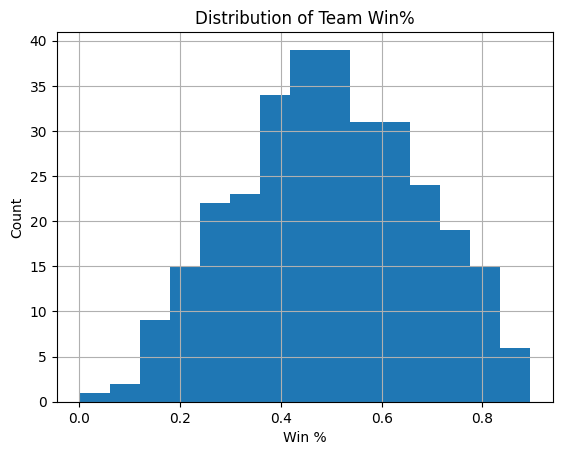

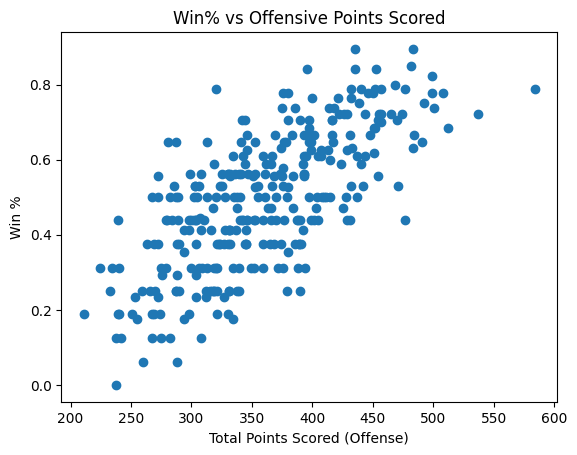

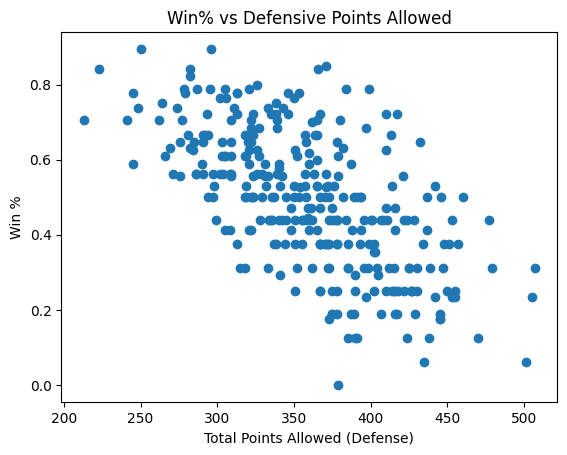

In [2]:
# 1.1 Histogram of win%
plt.figure()
df["win_pct"].hist(bins=15)
plt.xlabel("Win %")
plt.ylabel("Count")
plt.title("Distribution of Team Win%")
plt.show()

# 1.2 Off/def points vs win%
plt.figure()
plt.scatter(df["total_points_scored"], df["win_pct"])
plt.xlabel("Total Points Scored (Offense)")
plt.ylabel("Win %")
plt.title("Win% vs Offensive Points Scored")
plt.show()

plt.figure()
plt.scatter(df["total_points_allowed"], df["win_pct"])
plt.xlabel("Total Points Allowed (Defense)")
plt.ylabel("Win %")
plt.title("Win% vs Defensive Points Allowed")
plt.show()


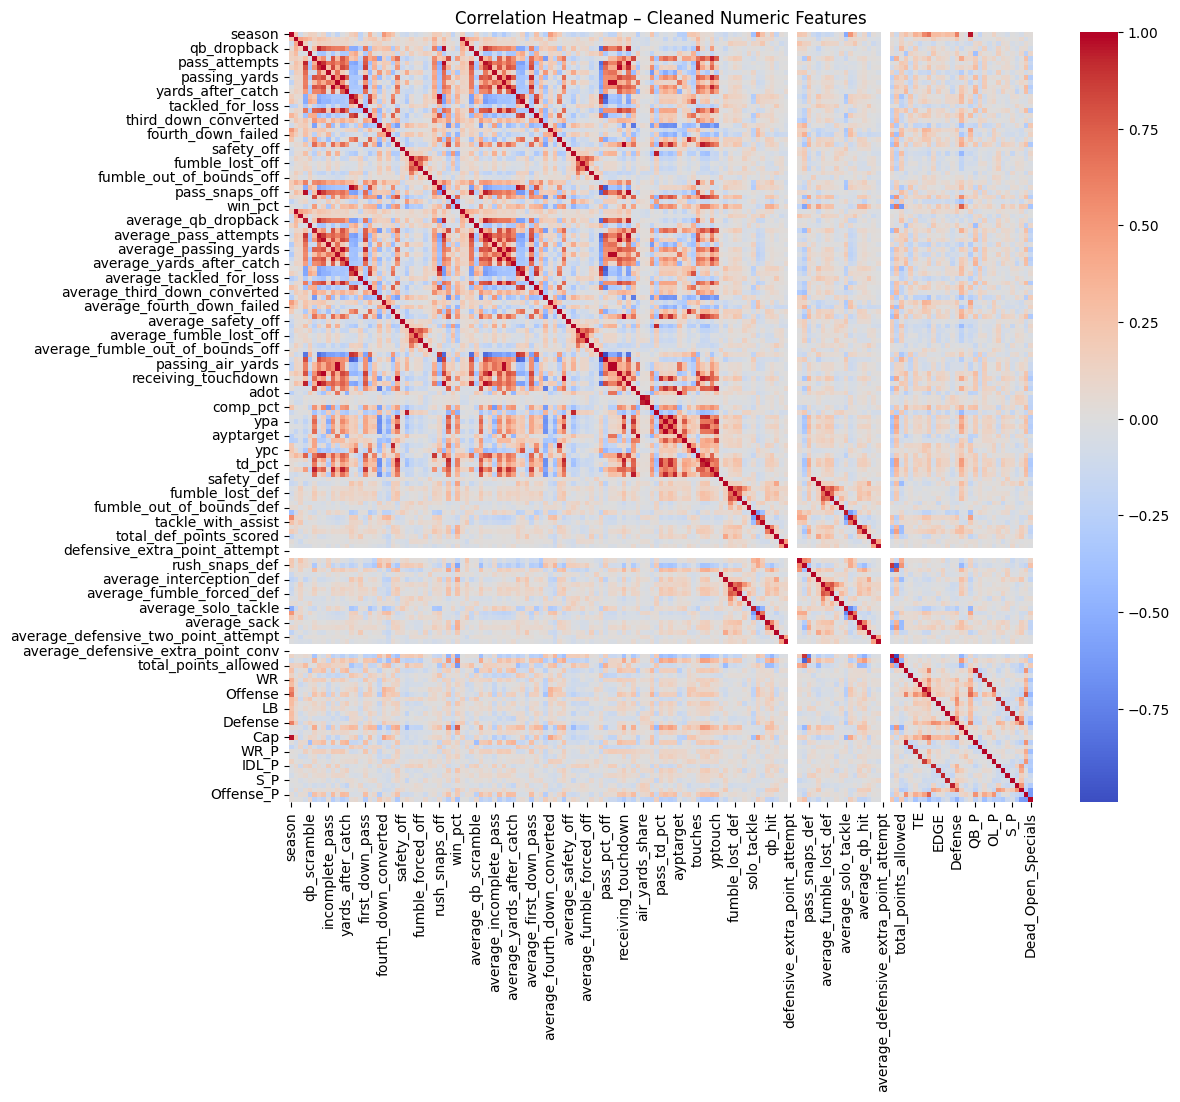

win_pct                         1.000000
Playoffs                        0.758818
total_points_scored             0.712935
pass_pct_def                    0.627926
total_tds                       0.621622
td_pct                          0.613725
rec_td_pct                      0.575400
pass_td_pct                     0.575400
pass_touchdown                  0.529147
receiving_touchdown             0.529147
average_pass_touchdown          0.516010
average_total_off_yards         0.489360
total_off_yards                 0.487946
yptarget                        0.467057
ypa                             0.464833
yps                             0.453427
interception_def                0.452838
average_interception_def        0.442053
average_rush_touchdown          0.425273
rush_touchdown                  0.414623
pass_snaps_def                  0.413292
total_yards                     0.409957
comp_pct                        0.405788
average_third_down_converted    0.399166
qb_hit          

In [3]:
# --- CLEAN UP BEFORE CORRELATION ---

# Remove non-predictive or duplicate columns for clarity
cols_to_drop = [
    "wins", "losses", "ties", "record", "W", "W_PCT",
    "team", "team_name_x", "team_name_y"
]

clean_df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Keep numeric columns only
numeric_df = clean_df.select_dtypes(include=[np.number])

# Compute full correlation matrix
corr_all = numeric_df.corr()

# 2.1 Heatmap of all numeric correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_all, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap – Cleaned Numeric Features")
plt.show()

# 2.2 Correlation with win% (top 30)
corr_with_win = corr_all["win_pct"].sort_values(ascending=False)
corr_with_win.head(30)


In [4]:
#looking for highly correlated pairs to remove obsolete/overlapping data
threshold = 0.97   
high_corr_pairs = []

cols = corr_all.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr_all.iloc[i, j]
        if abs(val) >= threshold:
            high_corr_pairs.append((cols[i], cols[j], val))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=["col1", "col2", "corr"])
high_corr_df.sort_values("corr", ascending=False).head(50)


,col1,col2,corr
43,passing_air_yards,receiving_air_yards,1.000000
7,complete_pass,receptions,1.000000
14,air_yards,receiving_air_yards,1.000000
13,air_yards,passing_air_yards,1.000000
45,pass_td_pct,rec_td_pct,1.000000
28,pass_touchdown,receiving_touchdown,1.000000
5,pass_attempts,targets,1.000000
44,adot,ayptarget,0.999996
38,average_passing_yards,average_receiving_yards,0.999893
9,passing_yards,receiving_yards,0.999891


In [5]:
# ------------------------------------------------------------
# RULE: KEEP all average_ columns
#       DROP total versions or mirrors that correlate > 0.98
# ------------------------------------------------------------

# Start with the known problematic ones
columns_to_drop = [

    # WIN% LEAKS
    "W", "W_PCT", "win_pct_off", "win_pct_def",
    "win_def", "win_off",

    # DUPLICATES & MIRRORS
    "Season",
    "receptions",
    "passing_air_yards",
    "receiving_air_yards",
    "receiving_yards",
    "receiving_touchdown",
    "rec_td_pct",
    "rush_snaps_off",

    # TOTALS that duplicate averages (from high-corr scan)
    "no_huddle",
    "shotgun",
    "qb_scramble",
    "qb_dropback",
    "pass_attempts",
    "complete_pass",
    "incomplete_pass",
    "passing_yards",
    "rushing_yards",
    "rush_attempts",
    "tackle_with_assist",
    "first_down_rush",
    "pass_touchdown",
    "defensive_two_point_conv",
    "defensive_two_point_attempt",
    "defensive_extra_point_attempt",
    "defensive_extra_point_conv",
    "tackled_for_loss",
    "def_touchdown",
    "yards_after_catch",
    "fumble_not_forced_def",
]

# Apply removal
df_clean = df.drop(columns=[c for c in columns_to_drop if c in df.columns], errors="ignore")

# ------------------------------------------------------------
# AUTO-DETECTION: drop any NON-average column that correlates 
#                 with an average_ column > 0.98
# ------------------------------------------------------------

numeric_df = df_clean.select_dtypes(include=[np.number])
corr = numeric_df.corr().abs()

to_drop_auto = set()

for col in corr.columns:
    for other in corr.columns:
        if col.startswith("average_") and other != col:
            if corr.loc[col, other] > 0.98:
                # drop the NON-average version
                if not other.startswith("average_") and other in df_clean.columns:
                    to_drop_auto.add(other)

df_clean = df_clean.drop(columns=list(to_drop_auto), errors="ignore")

print("Auto-removed (correlated totals):", to_drop_auto)
print("Final shape:", df_clean.shape)
df_clean.head()


Auto-removed (correlated totals): {'assist_tackle', 'interception_off', 'rush_touchdown', 'fumble_forced_off', 'total_def_points_scored', 'fourth_down_converted', 'fumble_lost_off', 'fumble_not_forced_off', 'safety_def', 'first_down_pass', 'sack', 'interception_def', 'fourth_down_failed', 'safety_off', 'fumble_lost_def'}
Final shape: (310, 129)


,team_x,season,season_type_x,total_off_yards,air_yards,third_down_converted,third_down_failed,fumble_off,fumble_out_of_bounds_off,offense_snaps,pass_snaps_off,total_points_scored,total_def_points,wins,losses,ties,record,win_pct,average_shotgun,average_no_huddle,average_qb_dropback,average_qb_scramble,average_total_off_yards,average_pass_attempts,average_complete_pass,average_incomplete_pass,average_passing_yards,average_air_yards,average_receiving_yards,average_yards_after_catch,average_rush_attempts,average_rushing_yards,average_tackled_for_loss,average_first_down_pass,average_first_down_rush,average_third_down_converted,average_third_down_failed,average_fourth_down_converted,average_fourth_down_failed,average_rush_touchdown,average_pass_touchdown,average_safety_off,average_interception_off,average_fumble_off,average_fumble_lost_off,average_fumble_forced_off,average_fumble_not_forced_off,average_fumble_out_of_bounds_off,rush_pct_off,pass_pct_off,targets,yps,adot,air_yards_share,target_share,comp_pct,int_pct,pass_td_pct,ypa,yptarget,ayptarget,ypr,rush_td_pct,ypc,touches,total_tds,td_pct,total_yards,yptouch,team_name,team_y,season_type_y,fumble_def,fumble_forced_def,fumble_out_of_bounds_def,solo_tackle,qb_hit,defense_snaps,rush_snaps_def,pass_snaps_def,average_safety_def,average_interception_def,average_fumble_def,average_fumble_lost_def,average_fumble_forced_def,average_fumble_not_forced_def,average_fumble_out_of_bounds_def,average_solo_tackle,average_assist_tackle,average_tackle_with_assist,average_sack,average_qb_hit,average_def_touchdown,average_defensive_two_point_attempt,average_defensive_two_point_conv,average_defensive_extra_point_attempt,average_defensive_extra_point_conv,rush_pct_def,pass_pct_def,total_points_allowed,Team_Season,QB,RB,WR,TE,OL,Offense,IDL,EDGE,LB,S,CB,Defense,Playoffs,SB,Cap,QB_P,RB_P,WR_P,TE_P,OL_P,IDL_P,EDGE_P,LB_P,S_P,CB_P,Defense_P,Offense_P,Dead_Open_Specials
0,ARI,2013,REG,5831,5284.0,74.0,136.0,20.0,3.0,1041,617,346.0,6.0,10.0,6.0,0.0,'10-6-0,0.625,25.937500,1.125000,38.875000,0.375000,364.437500,34.500000,22.687500,11.812500,268.187500,330.250000,268.187500,109.750000,26.437500,96.250000,2.437500,12.812500,5.250000,4.625000,8.500000,0.312500,0.250000,0.750000,1.500000,0.062500,1.375000,1.250000,0.562500,1.062500,0.187500,0.187500,0.39,0.59,552.0,5.60,9.572,1.087,0.940,0.658,0.040,0.043,7.77,7.77,9.57,11.82,0.028,3.64,1338.0,60.0,0.04,10122.0,7.57,Cardinals,ARI,REG,22.0,12.0,1.0,750.0,112.0,1044,362,669,0.125,1.250000,1.375000,0.625000,0.750000,0.625000,0.0625,46.875000,4.562500,1.687500,2.937500,7.000000,0.312500,0.0,0.0,0.0,0.0,0.35,0.64,321.0,Cardinals 2013,6172993.0,5306754.0,15022466.0,4425078.0,19171690.0,50098981.0,20498000.0,5347625.0,7964030.0,2809618.0,10407900.0,47027173.0,0.0,0.0,123600000.0,0.049943,0.042935,0.121541,0.035802,0.155111,0.165841,0.043266,0.064434,0.022732,0.084206,0.380479,0.405332,0.214190
1,ATL,2013,REG,5788,4468.0,89.0,118.0,16.0,2.0,1024,702,339.0,24.0,4.0,12.0,0.0,'4-12-0,0.250,40.687500,8.062500,44.375000,0.500000,361.750000,40.125000,27.812500,12.312500,283.812500,279.250000,283.750000,133.625000,20.062500,77.937500,2.250000,14.187500,4.000000,5.562500,7.375000,0.375000,0.500000,0.687500,1.625000,0.000000,1.062500,1.000000,0.625000,0.687500,0.312500,0.125000,0.31,0.69,642.0,5.65,6.960,4.857,8.676,0.693,0.026,0.040,7.07,7.07,6.96,10.20,0.034,3.88,1408.0,63.0,0.04,10328.0,7.34,Falcons,ATL,REG,19.0,15.0,0.0,636.0,55.0,1005,445,548,0.000,0.625000,1.187500,0.750000,0.937500,0.250000,0.0000,39.750000,11.687500,3.187500,2.000000,3.437500,0.187500,0.0,0.0,0.0,0.0,0.44,0.55,422.0,Falcons 2013,10920140.0,6293062.0,17406642.0,6938146.0,16464048.0,58022038.0,9806798.0,8139270.0,8433728.0,7249890.0,9276181.0,42905867.0,0.0,0.0,123600000.0,0.088351,0.050915,0.140830,0.056134,0.133204,0.079343,0.065852,0.068234,0.058656,0.075050,0.347135,0.469434,0.183431
2,BAL,2013,REG,5242,5781.0,92.0,161.0,17.0,1.0,1093,668,313.0,30.0,8.0,8.0,0.0,'8-8-0,0.500,53.125000,26.875000,42.812500

In [6]:
def high_corr_pairs(df, threshold=0.97):
    """
    Returns a dataframe showing all pairs of numeric columns that have
    absolute correlation above the chosen threshold.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()

    pairs = []
    cols = corr.columns

    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            val = corr.iloc[i, j]
            if abs(val) >= threshold:
                pairs.append((cols[i], cols[j], val))

    pairs_df = pd.DataFrame(pairs, columns=["col1", "col2", "corr"]) \
                   .sort_values("corr", ascending=False) \
                   .reset_index(drop=True)

    return pairs_df


In [7]:
pairs_after_cleaning = high_corr_pairs(df_clean, threshold=0.97)
pairs_after_cleaning


,col1,col2,corr
0,adot,ayptarget,0.999996
1,average_passing_yards,average_receiving_yards,0.999893
2,ypa,yptarget,0.999730
3,wins,win_pct,0.988708
4,fumble_off,average_fumble_off,0.979523
5,fumble_forced_def,average_fumble_forced_def,0.979391
6,fumble_out_of_bounds_def,average_fumble_out_of_bounds_def,0.978949
7,air_yards,average_air_yards,0.978466
8,qb_hit,average_qb_hit,0.978340
9,pass_snaps_off,targets,0.978166


In [8]:
# ============================================================
# FINAL DROP LIST (based on remaining high-corr pairs)
# ============================================================

final_drop_columns = [

    # 1. Passing/Receiving — keep averages, drop raw totals
    "ayptarget",                # keep adot + average versions
    "average_receiving_yards",  # identical to average_passing_yards? (shown in screenshot)
    "yptarget",

    # 2. Fumble correlations — totals too close to averages
    "fumble_off",
    "fumble_forced_def",
    "fumble_out_of_bounds_def",
    "fumble_def",
    "fumble_out_of_bounds_off",

    # 3. Air yards + QB hits — redundant with average versions
    "air_yards",
    "qb_hit",

    # 4. Snap/target metrics — totals correlate with average metrics
    "pass_snaps_off",
    "targets",

    # 5. Run/pass splits — both highly collinear
    "rush_pct_def",
    "rush_pct_off",

    # 6. Win% leaks (safety; some already removed earlier)
    "wins",
    "losses",
    "W",
    "W_PCT",
    "win_pct_off",
    "win_pct_def",
    "win_def",
    "win_off",
]

# Drop only columns that exist
final_drop_columns_existing = [c for c in final_drop_columns if c in df_clean.columns]

df_clean = df_clean.drop(columns=final_drop_columns_existing, errors="ignore")

print("Dropped:", final_drop_columns_existing)
print("New shape:", df_clean.shape)

# ============================================================
# RECHECK remaining high correlations
# ============================================================

corr = df_clean.select_dtypes(include=[np.number]).corr().abs()

remaining_pairs = []
cols = corr.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if corr.iloc[i, j] >= 0.97:
            remaining_pairs.append((cols[i], cols[j], corr.iloc[i, j]))

pd.DataFrame(remaining_pairs, columns=["col1", "col2", "corr"]).sort_values("corr", ascending=False).head(50)


Dropped: ['ayptarget', 'average_receiving_yards', 'yptarget', 'fumble_off', 'fumble_forced_def', 'fumble_out_of_bounds_def', 'fumble_def', 'fumble_out_of_bounds_off', 'air_yards', 'qb_hit', 'pass_snaps_off', 'targets', 'rush_pct_def', 'rush_pct_off', 'wins', 'losses']
New shape: (310, 113)


,col1,col2,corr


,col1,col2,corr


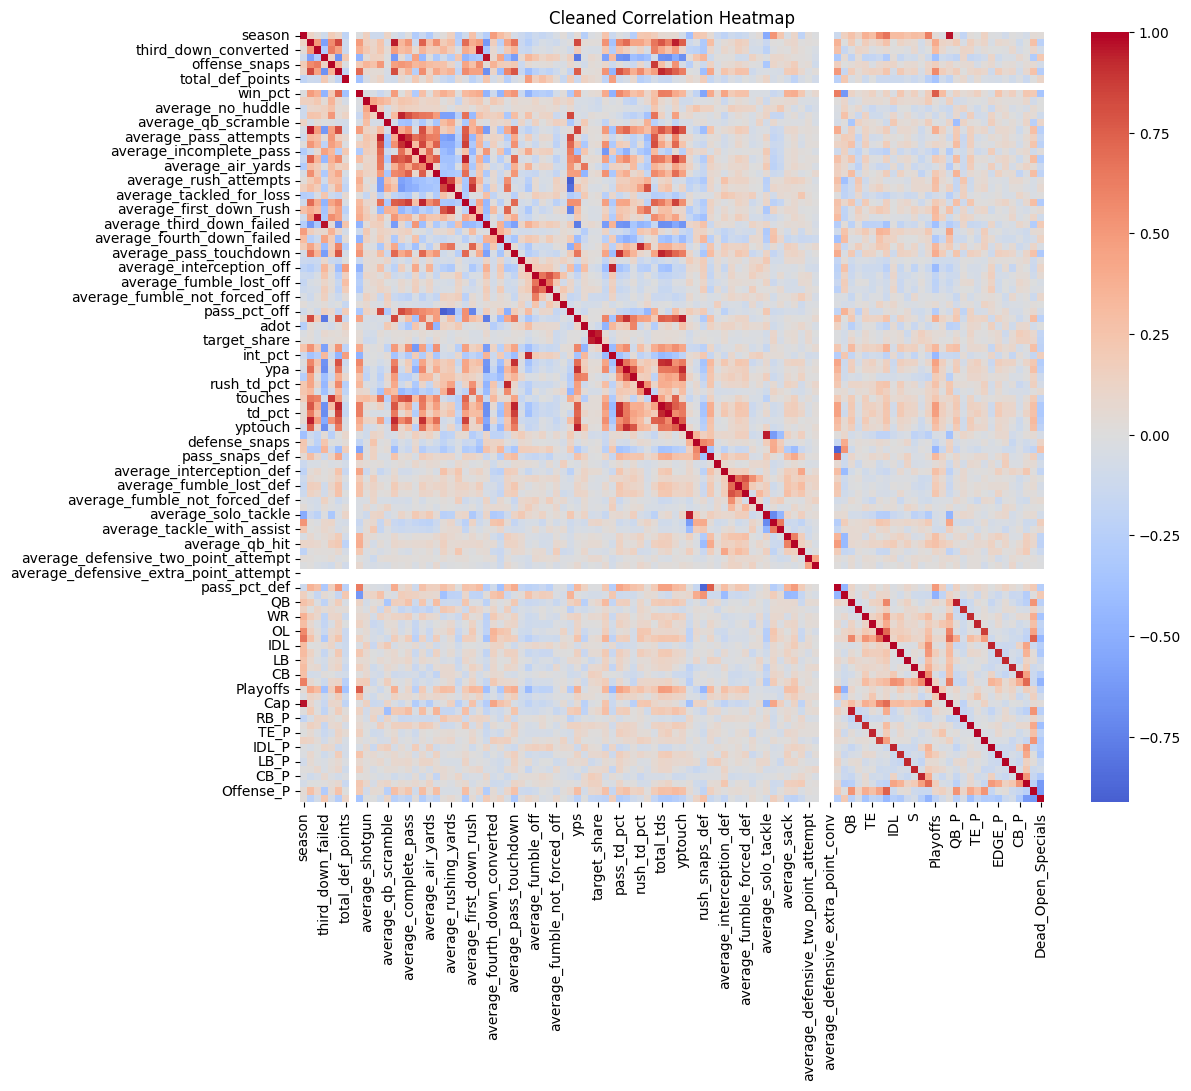

{'win_pct': win_pct                                  1.000000
 Playoffs                                 0.758818
 total_points_scored                      0.712935
 pass_pct_def                             0.627926
 total_tds                                0.621622
                                            ...   
 rush_snaps_def                          -0.555293
 total_points_allowed                    -0.631946
 ties                                          NaN
 average_defensive_extra_point_attempt         NaN
 average_defensive_extra_point_conv            NaN
 Name: win_pct, Length: 106, dtype: float64,
 'total_points_scored': total_points_scored                      1.000000
 total_tds                                0.927719
 td_pct                                   0.855045
 total_off_yards                          0.828929
 average_total_off_yards                  0.811102
                                            ...   
 third_down_failed                       -0.665059
 av

In [10]:
# --- 1. Check high-correlation pairs again ---
pairs_after_cleaning = high_corr_pairs(df_clean, threshold=0.97)
display(pairs_after_cleaning)

# --- 2. Build heatmap for cleaned dataset ---
numeric_clean = df_clean.select_dtypes(include=[np.number])
corr_clean = numeric_clean.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_clean, cmap="coolwarm", center=0)
plt.title("Cleaned Correlation Heatmap")
plt.show()

# --- 3. Correlations with four targets ---
targets = [
    "win_pct",
    "total_points_scored",     # offensive points
    "total_points_allowed",    # defensive allowed points (new merged column)
    "Playoffs"                 # playoff dummy from salary data
]

corr_tables = {}

for target in targets:
    if target in corr_clean.columns:
        corr_tables[target] = corr_clean[target].sort_values(ascending=False)
    else:
        print(f"WARNING: '{target}' not found in correlation matrix.")

corr_tables


In [11]:
# ============================
# MODELING SETUP
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, f1_score, roc_auc_score
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)


# ======================================================
# REMOVE `total_tds` — TOO COLLINEAR WITH SCORING
# ======================================================
if "total_tds" in df_clean.columns:
    df_clean = df_clean.drop(columns=["total_tds"])
    print("Removed total_tds due to high correlation with scoring metrics.")


# ======================================================
# DETECT CORRECT PLAYOFF COLUMN NAME
# ======================================================
if "Playoffs" in df_clean.columns:
    PLAYOFFS_COL = "Playoffs"
elif "playoffs" in df_clean.columns:
    PLAYOFFS_COL = "playoffs"
else:
    raise ValueError("Playoff column not found.")

print(f"Using playoff column: {PLAYOFFS_COL}")


Removed total_tds due to high correlation with scoring metrics.
Using playoff column: Playoffs


In [12]:
# ============================================================
# FEATURE SPLIT: SALARY vs NON-SALARY FEATURES
# ============================================================

# Salary % features (positional spending)
salary_features = [c for c in df_clean.columns if c.endswith("_P")]

# Correct target columns for your merged dataset
target_cols = [
    "win_pct",
    "total_points_scored",     # OFFENSE points
    "total_points_allowed",    # DEFENSE points allowed
    PLAYOFFS_COL               # categorical playoff outcome
]

# Identify ID-like columns to exclude from modeling
id_cols = [
    "season", 
    "team_name"                # if exists
]

# Remove team_name_x/y if they survived earlier steps
id_cols += [c for c in df_clean.columns if c.startswith("team_name_")]

# Remove scoring TD column (your rule)
if "total_tds" in df_clean.columns:
    df_clean = df_clean.drop(columns=["total_tds"])

# ============================================================
# NON-SALARY NUMERIC FEATURES
# ============================================================
non_salary_features = [
    c for c in df_clean.columns
    if c not in salary_features
    and c not in id_cols
    and c not in target_cols
    and df_clean[c].dtype in [np.float64, np.int64]
]

salary_features, non_salary_features[:15]


(['QB_P',
  'RB_P',
  'WR_P',
  'TE_P',
  'OL_P',
  'IDL_P',
  'EDGE_P',
  'LB_P',
  'S_P',
  'CB_P',
  'Defense_P',
  'Offense_P'],
 ['total_off_yards',
  'third_down_converted',
  'third_down_failed',
  'offense_snaps',
  'total_def_points',
  'ties',
  'average_shotgun',
  'average_no_huddle',
  'average_qb_dropback',
  'average_qb_scramble',
  'average_total_off_yards',
  'average_pass_attempts',
  'average_complete_pass',
  'average_incomplete_pass',
  'average_passing_yards'])

In [13]:
# ============================================================
# MODELING HELPER FUNCTIONS
# ============================================================

def run_regression_models(X, y):
    """
    Runs Linear Regression, Random Forest, and Gradient Boosting
    on the given feature/target set.
    """

    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(
            n_estimators=400, max_depth=None, random_state=42
        ),
        "GradientBoosting": GradientBoostingRegressor(
            random_state=42, learning_rate=0.05
        )
    }

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scale only for linear models
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    results = {}

    for name, model in models.items():

        # Scaled for linear only
        if name == "LinearRegression":
            model.fit(X_train_s, y_train)
            preds = model.predict(X_test_s)
        else:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

        results[name] = {
            "R2": r2_score(y_test, preds),
            "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
            "MAE": mean_absolute_error(y_test, preds)
        }

    return results



def run_classification_models(X, y):
    """
    Runs Logistic Regression, Random Forest, and Gradient Boosting
    on a binary classification target.
    """

    models = {
        "LogisticRegression": LogisticRegression(
            max_iter=3000, solver="lbfgs"
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=400, random_state=42
        ),
        "GradientBoosting": GradientBoostingClassifier(
            random_state=42, learning_rate=0.05
        )
    }

    # Train-test split (stratified for balanced target)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scaling for logistic regression
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    results = {}

    for name, model in models.items():

        if name == "LogisticRegression":
            model.fit(X_train_s, y_train)
            preds = model.predict(X_test_s)
            prob = model.predict_proba(X_test_s)[:, 1]
        else:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            prob = model.predict_proba(X_test)[:, 1]

        results[name] = {
            "Accuracy": accuracy_score(y_test, preds),
            "F1": f1_score(y_test, preds),
            "ROC_AUC": roc_auc_score(y_test, prob)
        }

    return results


In [14]:
# ============================================================
# SALARY-ONLY MODELS
# ============================================================

salary_X = df_clean[salary_features].copy()

print("=== SALARY-ONLY MODELS ===")

# Correct regression targets for merged dataset
regression_targets = [
    "win_pct",
    "total_points_scored",     # OFFENSE scoring
    "total_points_allowed"     # DEFENSE allowed
]

# ------------------------------------------------------------
#  REGRESSION TARGETS (SALARY ONLY)
# ------------------------------------------------------------
for target in regression_targets:
    if target not in df_clean.columns:
        print(f"\n[SKIP] Target '{target}' not found in df_clean.")
        continue

    print(f"\n--- Predicting {target} from SALARY ONLY ---")

    y = df_clean[target]

    res = run_regression_models(salary_X, y)
    display(pd.DataFrame(res).T)


# ------------------------------------------------------------
#  PLAYOFF CLASSIFICATION (SALARY ONLY)
# ------------------------------------------------------------
print("\n--- Predicting Playoffs from SALARY ONLY ---")

if PLAYOFFS_COL not in df_clean.columns:
    raise ValueError(f"Playoff column '{PLAYOFFS_COL}' missing from dataset.")

y = df_clean[PLAYOFFS_COL]

res = run_classification_models(salary_X, y)
display(pd.DataFrame(res).T)


=== SALARY-ONLY MODELS ===

--- Predicting win_pct from SALARY ONLY ---


,R2,RMSE,MAE
LinearRegression,0.137114,0.161234,0.134368
RandomForest,0.045905,0.169542,0.141175
GradientBoosting,0.030034,0.170946,0.146397



--- Predicting total_points_scored from SALARY ONLY ---


,R2,RMSE,MAE
LinearRegression,0.052478,66.241710,53.837977
RandomForest,-0.075281,70.566387,57.754435
GradientBoosting,-0.179560,73.908917,62.282962



--- Predicting total_points_allowed from SALARY ONLY ---


,R2,RMSE,MAE
LinearRegression,-0.083616,53.421734,44.307238
RandomForest,0.022240,50.745357,41.756774
GradientBoosting,-0.184259,55.847491,46.927178



--- Predicting Playoffs from SALARY ONLY ---


,Accuracy,F1,ROC_AUC
LogisticRegression,0.661290,0.461538,0.661184
RandomForest,0.564516,0.341463,0.573465
GradientBoosting,0.629032,0.410256,0.581140


In [15]:
# ============================================================
# NON-SALARY MODELS
# ============================================================

non_salary_X = df_clean[non_salary_features].copy()

print("=== NON-SALARY MODELS ===")

# Correct target names for merged dataset
regression_targets = [
    "win_pct",
    "total_points_scored",     # OFFENSE points
    "total_points_allowed"     # DEFENSE allowed points
]

# ------------------------------------------------------------
#  REGRESSION TARGETS (NON-SALARY FEATURES)
# ------------------------------------------------------------
for target in regression_targets:
    if target not in df_clean.columns:
        print(f"\n[SKIP] Target '{target}' not found in df_clean.")
        continue

    print(f"\n--- Predicting {target} from NON-SALARY stats ---")

    y = df_clean[target]
    res = run_regression_models(non_salary_X, y)

    display(pd.DataFrame(res).T)


# ------------------------------------------------------------
#  PLAYOFF CLASSIFICATION
# ------------------------------------------------------------
print("\n--- Predicting Playoffs from NON-SALARY stats ---")

if PLAYOFFS_COL not in df_clean.columns:
    raise ValueError(f"Playoff column '{PLAYOFFS_COL}' missing from dataset.")

y = df_clean[PLAYOFFS_COL]
res = run_classification_models(non_salary_X, y)

display(pd.DataFrame(res).T)


=== NON-SALARY MODELS ===

--- Predicting win_pct from NON-SALARY stats ---


,R2,RMSE,MAE
LinearRegression,0.683545,0.097642,0.071819
RandomForest,0.563246,0.114709,0.098619
GradientBoosting,0.624581,0.106350,0.088076



--- Predicting total_points_scored from NON-SALARY stats ---


,R2,RMSE,MAE
LinearRegression,0.950801,15.094336,11.650119
RandomForest,0.902061,21.296819,14.460202
GradientBoosting,0.912115,20.174126,13.667018



--- Predicting total_points_allowed from NON-SALARY stats ---


,R2,RMSE,MAE
LinearRegression,0.351710,41.320456,33.121505
RandomForest,0.305554,42.766098,35.736895
GradientBoosting,0.412347,39.340586,32.911415



--- Predicting Playoffs from NON-SALARY stats ---


,Accuracy,F1,ROC_AUC
LogisticRegression,0.709677,0.640000,0.841009
RandomForest,0.806452,0.727273,0.913377
GradientBoosting,0.774194,0.666667,0.868421


In [16]:
# ============================================================
# FULL FEATURE MODELS (Salary + Non-salary)
# ============================================================

full_feature_set = df_clean[salary_features + non_salary_features].copy()

print("=== FULL FEATURE MODELS ===")

# Correct regression targets for merged dataset
regression_targets = [
    "win_pct",
    "total_points_scored",     # OFFENSE scoring
    "total_points_allowed"     # DEFENSE points allowed
]

# ------------------------------------------------------------
#  REGRESSION TARGETS (ALL FEATURES)
# ------------------------------------------------------------
for target in regression_targets:
    if target not in df_clean.columns:
        print(f"\n[SKIP] Target '{target}' not found in df_clean.")
        continue

    print(f"\n--- Predicting {target} from ALL DATA ---")

    y = df_clean[target]

    res = run_regression_models(full_feature_set, y)
    display(pd.DataFrame(res).T)


# ------------------------------------------------------------
#  PLAYOFF CLASSIFICATION (ALL FEATURES)
# ------------------------------------------------------------
print("\n--- Predicting Playoffs from ALL DATA ---")

if PLAYOFFS_COL not in df_clean.columns:
    raise ValueError(f"Playoff column '{PLAYOFFS_COL}' missing from dataset.")

y = df_clean[PLAYOFFS_COL]

res = run_classification_models(full_feature_set, y)
display(pd.DataFrame(res).T)


=== FULL FEATURE MODELS ===

--- Predicting win_pct from ALL DATA ---


,R2,RMSE,MAE
LinearRegression,0.657189,0.101627,0.078774
RandomForest,0.556507,0.115591,0.099088
GradientBoosting,0.605544,0.109013,0.091453



--- Predicting total_points_scored from ALL DATA ---


,R2,RMSE,MAE
LinearRegression,0.944346,16.054031,12.621003
RandomForest,0.901694,21.336637,14.538468
GradientBoosting,0.912850,20.089599,13.304930



--- Predicting total_points_allowed from ALL DATA ---


,R2,RMSE,MAE
LinearRegression,0.354136,41.243055,33.323907
RandomForest,0.304107,42.810607,35.152540
GradientBoosting,0.413726,39.294394,32.320576



--- Predicting Playoffs from ALL DATA ---


,Accuracy,F1,ROC_AUC
LogisticRegression,0.725806,0.653061,0.844298
RandomForest,0.774194,0.666667,0.905702
GradientBoosting,0.790323,0.711111,0.908991


In [17]:
# ============================================================
# CLASSIFICATION COMPARISON (RANDOM FOREST AUC)
# ============================================================

print("\n=== AUC Comparison for Playoff Prediction ===")

# Salary-only model
salary_res = run_classification_models(salary_X, df_clean[PLAYOFFS_COL])
salary_AUC = salary_res["RandomForest"]["ROC_AUC"]

# Non-salary model
nonsalary_res = run_classification_models(non_salary_X, df_clean[PLAYOFFS_COL])
nonsalary_AUC = nonsalary_res["RandomForest"]["ROC_AUC"]

# Combined model
combined_res = run_classification_models(full_feature_set, df_clean[PLAYOFFS_COL])
combined_AUC = combined_res["RandomForest"]["ROC_AUC"]

# Display results cleanly
print("Salary-Only AUC:    ", round(salary_AUC, 4))
print("Non-Salary AUC:     ", round(nonsalary_AUC, 4))
print("Combined Full AUC:  ", round(combined_AUC, 4))



=== AUC Comparison for Playoff Prediction ===
Salary-Only AUC:     0.5735
Non-Salary AUC:      0.9134
Combined Full AUC:   0.9057


In [18]:
# ============================================================
# RANDOM FOREST REGRESSION COMPARISON
# ============================================================

def get_rf_reg_metrics(X, y):
    """Train a RandomForestRegressor and return (R2, RMSE, MAE)."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = RandomForestRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    r2  = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    return r2, rmse, mae


# Correct regression target names for merged dataset
regression_targets = [
    "win_pct",
    "total_points_scored",     # replaces total_off_points
    "total_points_allowed"     # replaces total_def_points
]

print("======== REGRESSION PERFORMANCE COMPARISONS ========")

for target in regression_targets:
    print(f"\n### Target: {target}")

    if target not in df_clean.columns:
        print(f"[SKIP] Target '{target}' not found in df_clean.")
        continue

    y = df_clean[target]

    # Salary-only
    r2_s, rmse_s, mae_s = get_rf_reg_metrics(salary_X, y)

    # Non-salary
    r2_ns, rmse_ns, mae_ns = get_rf_reg_metrics(non_salary_X, y)

    # Combined
    r2_c, rmse_c, mae_c = get_rf_reg_metrics(full_feature_set, y)

    comparison_table = pd.DataFrame({
        "Model Type": ["Salary Only", "Non-Salary Only", "Combined"],
        "R2": [r2_s, r2_ns, r2_c],
        "RMSE": [rmse_s, rmse_ns, rmse_c],
        "MAE": [mae_s, mae_ns, mae_c]
    })

    display(comparison_table)


======== REGRESSION PERFORMANCE COMPARISONS ========

### Target: win_pct


,Model Type,R2,RMSE,MAE
0,Salary Only,0.054217,0.168802,0.140956
1,Non-Salary Only,0.568545,0.114011,0.097955
2,Combined,0.563763,0.114642,0.098074



### Target: total_points_scored


,Model Type,R2,RMSE,MAE
0,Salary Only,-0.085273,70.893499,58.163441
1,Non-Salary Only,0.901247,21.385089,14.538602
2,Combined,0.901339,21.375210,14.662366



### Target: total_points_allowed


,Model Type,R2,RMSE,MAE
0,Salary Only,0.021780,50.757315,41.759247
1,Non-Salary Only,0.315407,42.461620,35.575538
2,Combined,0.312042,42.565843,35.086882


In [19]:
# ================================================================
# FULL FEATURE SELECTION PIPELINE FOR REGRESSION + CLASSIFICATION
# ================================================================

from sklearn.feature_selection import (
    SelectKBest, f_regression, mutual_info_classif,
    RFE, VarianceThreshold
)
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# ============================================================
#  REGRESSION METRICS HELPER
#  (Random Forest — matches earlier blocks)
# ============================================================
def get_rf_reg_metrics(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = RandomForestRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return (
        r2_score(y_test, preds),
        np.sqrt(mean_squared_error(y_test, preds)),
        mean_absolute_error(y_test, preds)
    )


# ============================================================
#  CLASSIFICATION METRICS HELPER
#  (Random Forest — consistent with earlier blocks)
# ============================================================
def get_rf_clf_metrics(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    model = RandomForestClassifier(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]

    return (
        accuracy_score(y_test, preds),
        f1_score(y_test, preds),
        roc_auc_score(y_test, prob)
    )


In [20]:
# ================================================================
# Target variables
# ================================================================

# Correct regression targets for cleaned + merged dataset
regression_targets = [
    "win_pct",
    "total_points_scored",     # replaces total_off_points
    "total_points_allowed"     # replaces total_def_points
]

# Classification target already detected earlier
classification_target = PLAYOFFS_COL

# Feature set (salary + non-salary predictive features)
X_all = full_feature_set.copy()

print("Regression targets:", regression_targets)
print("Classification target:", classification_target)
print("Full feature set shape:", X_all.shape)


Regression targets: ['win_pct', 'total_points_scored', 'total_points_allowed']
Classification target: Playoffs
Full feature set shape: (310, 100)


In [21]:
# ================================================================
# FEATURE SELECTION METHOD 1 — Variance Threshold
# ================================================================

vt_selector = VarianceThreshold(threshold=0.01)
vt_selector.fit(X_all)
vt_features = X_all.columns[vt_selector.get_support()].tolist()

print("Variance Threshold Selected Features:", len(vt_features))


Variance Threshold Selected Features: 70


In [22]:
# ================================================================
# FEATURE SELECTION METHOD 2 — SelectKBest (Regression + Classification)
# ================================================================

k = 20  # Adjustable

# ------------------------------------------------
# SelectKBest for regression (Example target: win_pct)
# ------------------------------------------------
reg_target = "win_pct"   # choose primary regression target
if reg_target not in df_clean.columns:
    raise ValueError(f"Regression target '{reg_target}' not found in dataset.")

skb_reg = SelectKBest(f_regression, k=k)
skb_reg.fit(X_all, df_clean[reg_target])
skb_reg_features = X_all.columns[skb_reg.get_support()].tolist()

# ------------------------------------------------
# SelectKBest for classification (Playoffs)
# ------------------------------------------------
if classification_target not in df_clean.columns:
    raise ValueError(f"Classification target '{classification_target}' not found.")

skb_clf = SelectKBest(mutual_info_classif, k=k)
skb_clf.fit(X_all, df_clean[classification_target])
skb_clf_features = X_all.columns[skb_clf.get_support()].tolist()

print("SelectKBest (Regression win_pct) Features:", skb_reg_features)
print("SelectKBest (Classification Playoffs) Features:", skb_clf_features)


SelectKBest (Regression win_pct) Features: ['total_off_yards', 'third_down_failed', 'average_total_off_yards', 'average_third_down_converted', 'average_third_down_failed', 'average_fourth_down_failed', 'average_rush_touchdown', 'average_pass_touchdown', 'average_interception_off', 'yps', 'comp_pct', 'int_pct', 'pass_td_pct', 'ypa', 'td_pct', 'total_yards', 'rush_snaps_def', 'pass_snaps_def', 'average_interception_def', 'pass_pct_def']
SelectKBest (Classification Playoffs) Features: ['average_tackled_for_loss', 'average_third_down_converted', 'average_fourth_down_converted', 'average_fourth_down_failed', 'average_rush_touchdown', 'average_pass_touchdown', 'average_interception_off', 'average_fumble_off', 'average_fumble_lost_off', 'average_fumble_forced_off', 'average_fumble_not_forced_off', 'average_fumble_out_of_bounds_off', 'average_interception_def', 'average_fumble_def', 'average_fumble_lost_def', 'average_fumble_forced_def', 'average_fumble_not_forced_def', 'average_fumble_out_of_

In [23]:
# ================================================================
# FEATURE SELECTION METHOD 3 — RFE (Wrapper Method)
# ================================================================

rfe_estimator = RandomForestRegressor(n_estimators=200, random_state=42)
rfe_n_features = 20   # Tune this as needed

rfe_results = {}

for target in regression_targets:  # ["win_pct", "total_points_scored", "total_points_allowed"]
    
    if target not in df_clean.columns:
        print(f"[SKIP] Target '{target}' not found in dataset.")
        continue

    print(f"\nRunning RFE for target: {target}")

    rfe_selector = RFE(
        estimator=rfe_estimator,
        n_features_to_select=rfe_n_features,
        step=1
    )
    
    rfe_selector.fit(X_all, df_clean[target])

    selected_features = X_all.columns[rfe_selector.get_support()].tolist()

    rfe_results[target] = selected_features
    print("Selected features:", selected_features)



Running RFE for target: win_pct
Selected features: ['EDGE_P', 'Defense_P', 'total_off_yards', 'average_rush_attempts', 'average_first_down_rush', 'average_third_down_failed', 'average_fourth_down_failed', 'average_rush_touchdown', 'average_pass_touchdown', 'average_interception_off', 'average_fumble_forced_off', 'comp_pct', 'int_pct', 'pass_td_pct', 'td_pct', 'rush_snaps_def', 'average_interception_def', 'average_sack', 'average_qb_hit', 'pass_pct_def']

Running RFE for target: total_points_scored
Selected features: ['total_off_yards', 'offense_snaps', 'average_total_off_yards', 'average_rush_attempts', 'average_first_down_rush', 'average_third_down_converted', 'average_third_down_failed', 'average_fourth_down_failed', 'average_rush_touchdown', 'average_pass_touchdown', 'average_fumble_forced_off', 'int_pct', 'pass_td_pct', 'rush_td_pct', 'touches', 'td_pct', 'total_yards', 'pass_snaps_def', 'average_interception_def', 'pass_pct_def']

Running RFE for target: total_points_allowed
Sele

In [24]:
# ================================================================
# FEATURE SELECTION METHOD 4 — LASSO (Embedded Method)
# ================================================================
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Objective did not converge")

lasso_results = {}

lasso_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("lasso", LassoCV(cv=5, random_state=42))
])

for target in regression_targets:  # ["win_pct", "total_points_scored", "total_points_allowed"]

    if target not in df_clean.columns:
        print(f"[SKIP] Target '{target}' not found.")
        continue

    print(f"\nRunning LASSO for target: {target}")

    # Fit pipeline
    lasso_pipe.fit(X_all, df_clean[target])

    # Extract coefficients
    coef = lasso_pipe.named_steps["lasso"].coef_
    
    lasso_features = X_all.columns[coef != 0].tolist()
    lasso_results[target] = lasso_features

    print("LASSO Selected Features:", lasso_features)



Running LASSO for target: win_pct
LASSO Selected Features: ['EDGE_P', 'S_P', 'Defense_P', 'third_down_converted', 'total_def_points', 'average_yards_after_catch', 'average_third_down_failed', 'average_fourth_down_converted', 'average_fourth_down_failed', 'average_rush_touchdown', 'average_fumble_off', 'average_fumble_lost_off', 'average_fumble_forced_off', 'average_fumble_out_of_bounds_off', 'pass_pct_off', 'comp_pct', 'int_pct', 'ypc', 'touches', 'td_pct', 'defense_snaps', 'average_safety_def', 'average_interception_def', 'average_fumble_def', 'average_fumble_not_forced_def', 'average_tackle_with_assist', 'average_sack', 'average_qb_hit', 'average_def_touchdown', 'pass_pct_def', 'SB', 'Dead_Open_Specials']

Running LASSO for target: total_points_scored
LASSO Selected Features: ['WR_P', 'EDGE_P', 'LB_P', 'Defense_P', 'total_off_yards', 'total_def_points', 'average_first_down_rush', 'average_third_down_failed', 'average_fourth_down_failed', 'average_rush_touchdown', 'average_pass_touch

In [25]:
# ================================================================
# FEATURE SELECTION METHOD 5 — RandomForest Importance
# ================================================================

rf_top_features = {}
N = 20  # number of top features to keep

for target in regression_targets:  # ["win_pct", "total_points_scored", "total_points_allowed"]

    if target not in df_clean.columns:
        print(f"[SKIP] Target '{target}' not found.")
        continue

    print(f"\nRunning RF Importance for regression target: {target}")

    rf = RandomForestRegressor(
        n_estimators=400, 
        random_state=42,
        max_depth=None
    )
    
    rf.fit(X_all, df_clean[target])

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_features = X_all.columns[indices[:N]].tolist()
    rf_top_features[target] = top_features

    print("Top RF features:", top_features)



Running RF Importance for regression target: win_pct
Top RF features: ['pass_pct_def', 'pass_td_pct', 'rush_snaps_def', 'average_interception_def', 'average_interception_off', 'td_pct', 'int_pct', 'average_fourth_down_failed', 'average_rush_touchdown', 'average_sack', 'comp_pct', 'average_rush_attempts', 'total_off_yards', 'average_pass_touchdown', 'average_fumble_off', 'average_first_down_rush', 'average_qb_hit', 'ypa', 'average_third_down_failed', 'total_def_points']

Running RF Importance for regression target: total_points_scored
Top RF features: ['total_off_yards', 'td_pct', 'average_total_off_yards', 'average_pass_touchdown', 'average_rush_touchdown', 'pass_td_pct', 'rush_td_pct', 'yps', 'average_first_down_rush', 'offense_snaps', 'total_yards', 'pass_pct_def', 'pass_snaps_def', 'average_third_down_failed', 'touches', 'average_fumble_forced_off', 'int_pct', 'average_interception_def', 'average_fourth_down_failed', 'average_rush_attempts']

Running RF Importance for regression ta

In [26]:
# ================================================================
# MASTER COMPARISON TABLE
# ================================================================

comparison_rows = []

# Unified feature-selection dictionary (multi-target friendly)
methods = {
    "VarianceThreshold": {t: vt_features for t in regression_targets},

    "SelectKBest_Reg": {  # regression only
        "win_pct": skb_reg_features,
        "total_points_scored": skb_reg_features,
        "total_points_allowed": skb_reg_features
    },

    "SelectKBest_Clf": {  # classification only
        classification_target: skb_clf_features
    },

    "RFE": rfe_results,             # dict: target → features
    "LASSO": lasso_results,         # dict: target → features
    "RF_Importance": rf_top_features  # dict: target → features
}

# ---------------------------------------------------------------
# Loop through selection methods
# ---------------------------------------------------------------
for method_name, feature_dict in methods.items():

    for target in regression_targets:

        if target not in feature_dict:
            # Skip methods that do not apply to certain targets
            continue

        feature_list = feature_dict[target]
        X_sel = X_all[feature_list]

        y = df_clean[target]
        r2, rmse, mae = get_rf_reg_metrics(X_sel, y)

        comparison_rows.append([
            method_name, target, "Regression",
            r2, rmse, mae
        ])

    # Classification (only one target)
    if classification_target in feature_dict:
        feature_list = feature_dict[classification_target]
        X_sel = X_all[feature_list]

        y = df_clean[classification_target]
        acc, f1, auc = get_rf_clf_metrics(X_sel, y)

        comparison_rows.append([
            method_name, classification_target, "Classification",
            acc, f1, auc
        ])


comparison_df = pd.DataFrame(
    comparison_rows,
    columns=["Method", "Target", "Type", "Score (R2/Acc)", "Metric2 (RMSE/F1)", "Metric3 (MAE/AUC)"]
)

comparison_df


,Method,Target,Type,Score (R2/Acc),Metric2 (RMSE/F1),Metric3 (MAE/AUC)
0,VarianceThreshold,win_pct,Regression,0.606743,0.108848,0.090691
1,VarianceThreshold,total_points_scored,Regression,0.859532,25.505011,16.921882
2,VarianceThreshold,total_points_allowed,Regression,0.316610,42.424278,35.274462
3,SelectKBest_Reg,win_pct,Regression,0.585444,0.111756,0.094735
4,SelectKBest_Reg,total_points_scored,Regression,0.913573,20.006018,13.719677
5,SelectKBest_Reg,total_points_allowed,Regression,0.235409,44.874008,37.595914
6,SelectKBest_Clf,Playoffs,Classification,0.854839,0.780488,0.922149
7,RFE,win_pct,Regression,0.590777,0.111035,0.093543
8,RFE,total_points_scored,Regression,0.916509,19.663335,13.010108
9,RFE,total_points_allowed,Regression,0.385619,40.225284,33.404086


In [27]:
# ================================================================
# Rank Feature Selection Methods for ALL Targets
# ================================================================

best_methods = {}

for target in regression_targets + [classification_target]:
    print(f"\n=== Best Feature Selection Methods for Target: {target} ===")

    # Filter table for this target
    target_table = comparison_df[comparison_df["Target"] == target]

    # REGRESSION TARGETS
    if target in regression_targets:
        # Higher R² is better
        sorted_table = target_table.sort_values("Score (R2/Acc)", ascending=False)
        display(sorted_table)

        best_method = sorted_table.iloc[0]["Method"]
        best_methods[target] = best_method

    # CLASSIFICATION TARGET (Playoffs)
    else:
        # Higher AUC is better (stored in Metric3 column)
        sorted_table = target_table.sort_values("Metric3 (MAE/AUC)", ascending=False)
        display(sorted_table)

        best_method = sorted_table.iloc[0]["Method"]
        best_methods[target] = best_method

print("\n\n=== SUMMARY: Best Feature Selection Method Per Target ===")
for target, method in best_methods.items():
    print(f"{target}: {method}")



=== Best Feature Selection Methods for Target: win_pct ===


,Method,Target,Type,Score (R2/Acc),Metric2 (RMSE/F1),Metric3 (MAE/AUC)
10,LASSO,win_pct,Regression,0.631773,0.105327,0.088395
0,VarianceThreshold,win_pct,Regression,0.606743,0.108848,0.090691
13,RF_Importance,win_pct,Regression,0.603943,0.109234,0.091221
7,RFE,win_pct,Regression,0.590777,0.111035,0.093543
3,SelectKBest_Reg,win_pct,Regression,0.585444,0.111756,0.094735



=== Best Feature Selection Methods for Target: total_points_scored ===


,Method,Target,Type,Score (R2/Acc),Metric2 (RMSE/F1),Metric3 (MAE/AUC)
8,RFE,total_points_scored,Regression,0.916509,19.663335,13.010108
4,SelectKBest_Reg,total_points_scored,Regression,0.913573,20.006018,13.719677
14,RF_Importance,total_points_scored,Regression,0.911919,20.196610,13.391505
11,LASSO,total_points_scored,Regression,0.907754,20.668535,13.501989
1,VarianceThreshold,total_points_scored,Regression,0.859532,25.505011,16.921882



=== Best Feature Selection Methods for Target: total_points_allowed ===


,Method,Target,Type,Score (R2/Acc),Metric2 (RMSE/F1),Metric3 (MAE/AUC)
9,RFE,total_points_allowed,Regression,0.385619,40.225284,33.404086
12,LASSO,total_points_allowed,Regression,0.381851,40.348448,33.202849
15,RF_Importance,total_points_allowed,Regression,0.371505,40.684713,33.291828
2,VarianceThreshold,total_points_allowed,Regression,0.316610,42.424278,35.274462
5,SelectKBest_Reg,total_points_allowed,Regression,0.235409,44.874008,37.595914



=== Best Feature Selection Methods for Target: Playoffs ===


,Method,Target,Type,Score (R2/Acc),Metric2 (RMSE/F1),Metric3 (MAE/AUC)
6,SelectKBest_Clf,Playoffs,Classification,0.854839,0.780488,0.922149




=== SUMMARY: Best Feature Selection Method Per Target ===
win_pct: LASSO
total_points_scored: RFE
total_points_allowed: RFE
Playoffs: SelectKBest_Clf


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ============================================
# SETUP OUTPUT DIRECTORY
# ============================================
output_dir = "model_outputs"
os.makedirs(output_dir, exist_ok=True)

print(f"Saving all graphs + tables to: {output_dir}/")


Saving all graphs + tables to: model_outputs/


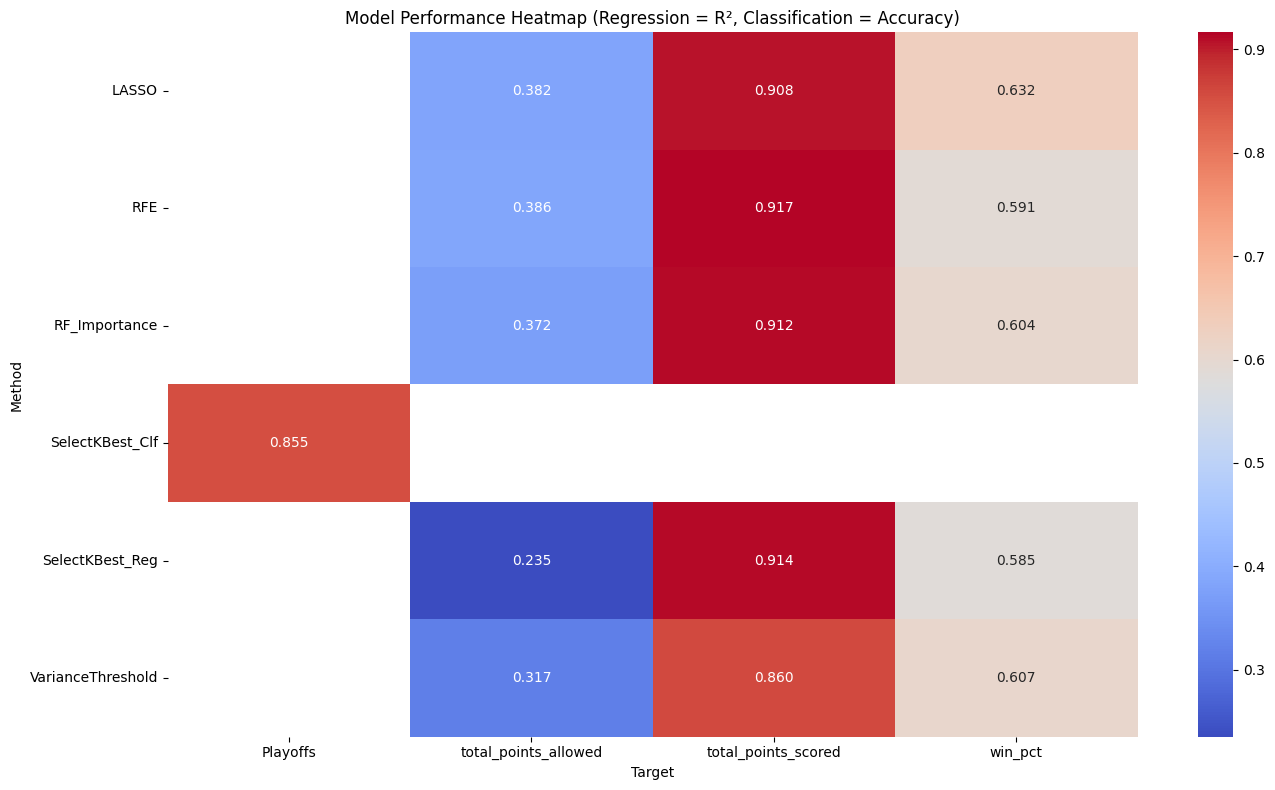

In [29]:
# ============================================
# GRAPH 1: Heatmap of Performance by Method/Target
# ============================================

plt.figure(figsize=(14, 8))

# Use correct column name
pivot = comparison_df.pivot(index="Method", columns="Target", values="Score (R2/Acc)")

sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Model Performance Heatmap (Regression = R², Classification = Accuracy)")
plt.tight_layout()

plt.savefig(f"{output_dir}/performance_heatmap.png")
plt.show()


/var/folders/vq/vh3dv7_d1736s_z9vmr42jvh0000gn/T/ipykernel_51014/2645474562.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=targets, y=methods, palette="viridis")


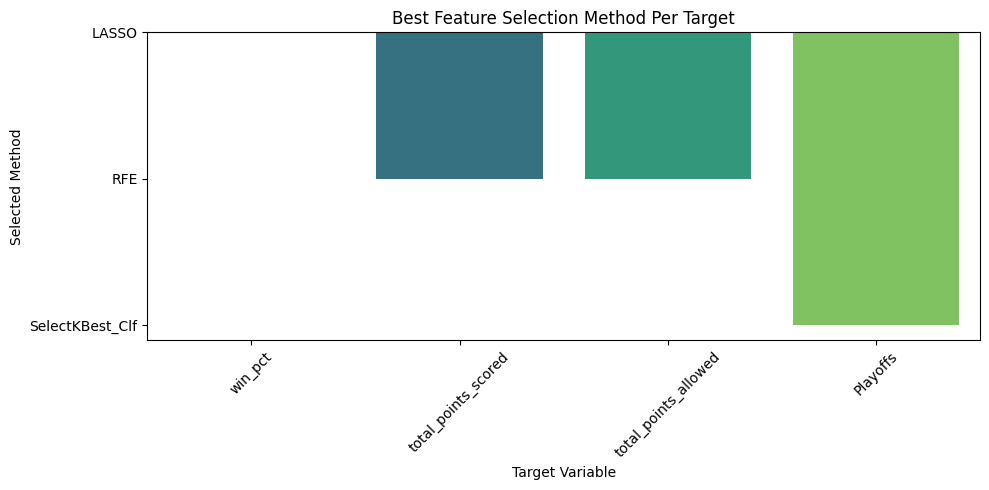

In [30]:
# ============================================
# GRAPH 2: Best Feature-Selection Method Per Target
# ============================================

plt.figure(figsize=(10, 5))

targets = list(best_methods.keys())
methods = list(best_methods.values())

sns.barplot(x=targets, y=methods, palette="viridis")

plt.title("Best Feature Selection Method Per Target")
plt.xlabel("Target Variable")
plt.ylabel("Selected Method")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f"{output_dir}/best_methods.png")
plt.show()


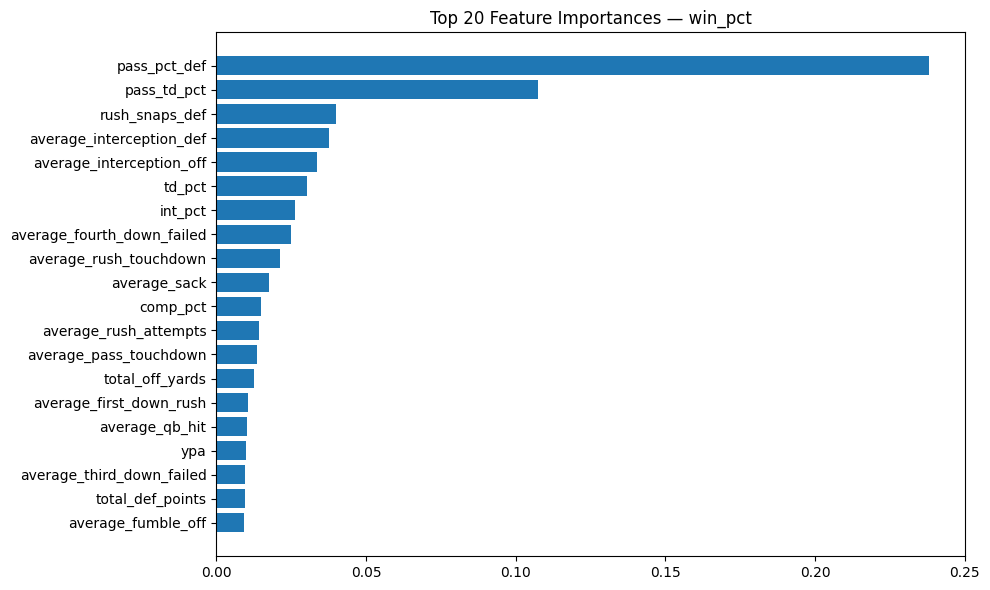

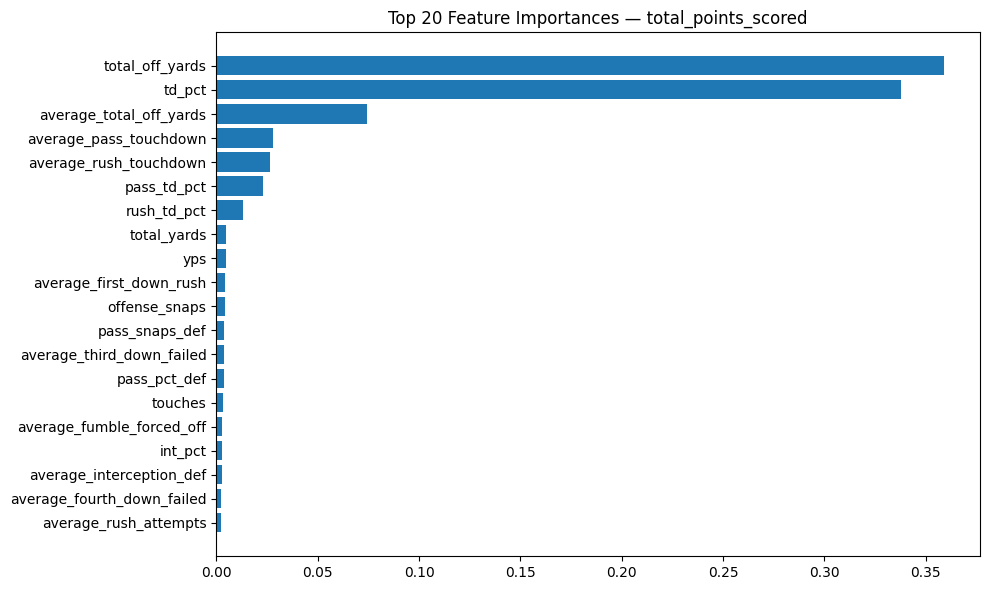

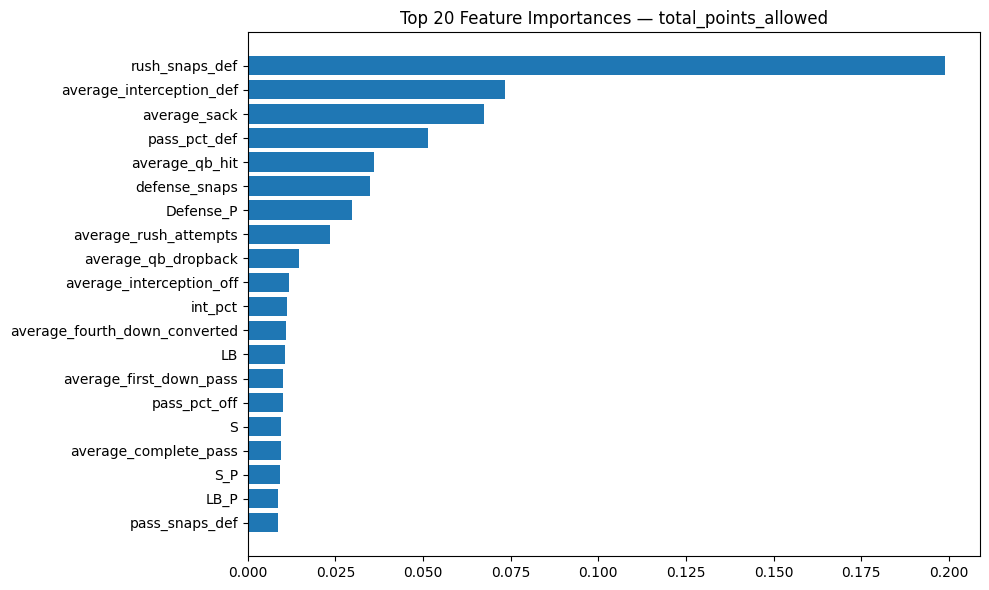

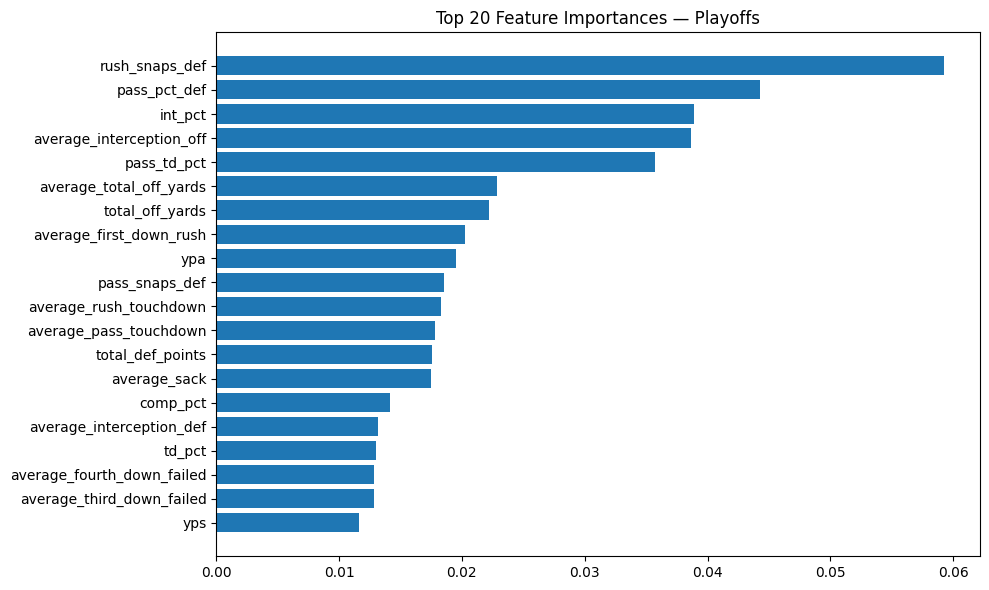

In [31]:
# ============================================
# GRAPH 3: Feature Importances (RandomForest)
# ============================================

def plot_rf_importance(X, y, title):
    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(10, 6))
    plt.barh(X.columns[idx], importances[idx])
    plt.gca().invert_yaxis()
    plt.title(f"Top 20 Feature Importances — {title}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/rf_importance_{title}.png")
    plt.show()


# ------------------------------------------------------------
#  Regression targets (corrected names)
# ------------------------------------------------------------
for target in ["win_pct", "total_points_scored", "total_points_allowed"]:
    plot_rf_importance(full_feature_set, df_clean[target], target)


# ------------------------------------------------------------
#  Classification feature importance
# ------------------------------------------------------------
def plot_rf_classification_importance(X, y, title):
    rf = RandomForestClassifier(n_estimators=300, random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(10, 6))
    plt.barh(X.columns[idx], importances[idx])
    plt.gca().invert_yaxis()
    plt.title(f"Top 20 Feature Importances — {title}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/rf_importance_{title}.png")
    plt.show()


plot_rf_classification_importance(full_feature_set, df_clean[PLAYOFFS_COL], PLAYOFFS_COL)


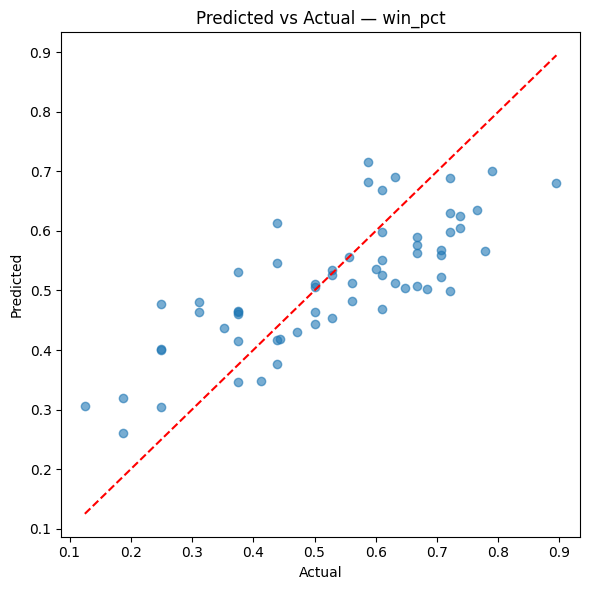

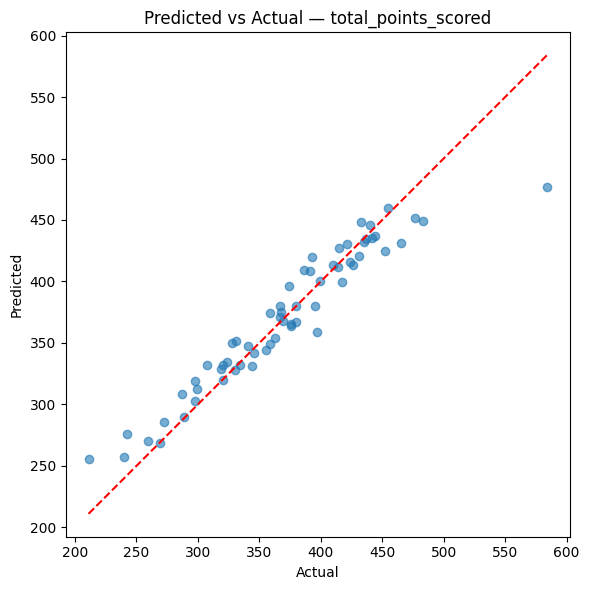

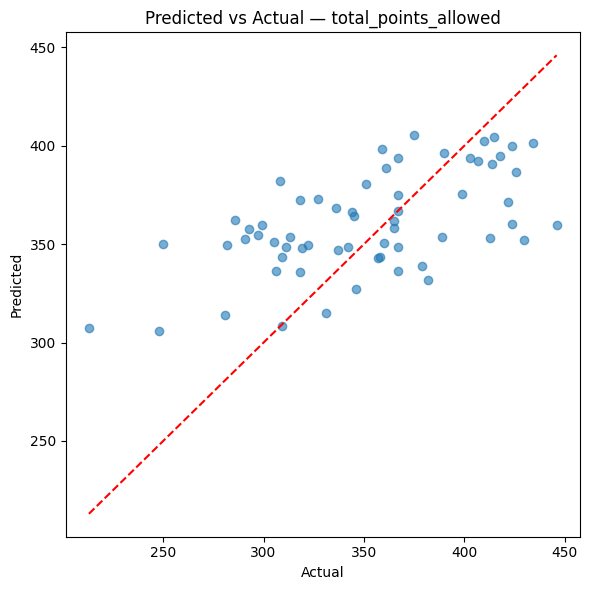

In [32]:
# ============================================
# GRAPH 4: Predicted vs Actual (for each regression target)
# ============================================

from sklearn.ensemble import RandomForestRegressor

def plot_pred_vs_actual(X, y, title):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, preds, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs Actual — {title}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/pred_vs_actual_{title}.png")
    plt.show()


# Use correct regression targets
for target in ["win_pct", "total_points_scored", "total_points_allowed"]:
    plot_pred_vs_actual(full_feature_set, df_clean[target], target)


In [33]:
# ============================================
# EXPORT TABLES
# ============================================

# 1. Feature Selection Comparison Table
comparison_df.to_csv(f"{output_dir}/comparison_table.csv", index=False)

# 2. Best Method Per Target
pd.DataFrame(best_methods.items(), columns=["Target", "Best_Method"]) \
  .to_csv(f"{output_dir}/best_methods.csv", index=False)

# 3. Raw Correlation Tables for Each Target
# (using correct variable name: corr_tables)
for target, corr_table in corr_tables.items():
    corr_table.to_csv(f"{output_dir}/correlations_{target}.csv", header=True)

print("\nAll tables exported successfully!")



All tables exported successfully!
